<a href="https://colab.research.google.com/github/AnIsAsPe/Regresion-Robusta-para-estimar-tiempo-de-respuesta-de-un-servicio-de-emergencia/blob/main/Notebooks/1_Response_time_Paris_Fire_Brigade_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar bibiliotecas y funciones

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def correlacion(dataframe, grafica=True, matrix=False, tamaño =(12,8)):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr=dataframe.corr()
    if grafica==True:
      fig = plt.figure(figsize = tamaño)
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm",
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(),
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

In [4]:
def describe_datos(df):
  unicos =[]
  for col in df:
    unicos.append(df[col].unique())
  unicos = pd.Series(unicos, index=df.columns)
  descripcion = pd.concat([df.dtypes, df.isna().sum(),df.nunique(),unicos], axis=1)
  descripcion.columns = ['dtypes', 'null','nunique','unique' ]
  return(descripcion)

# Lectura datos y selección de características

__Cargar etiquetas__

In [5]:
# Variables respuesta
Ys = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/y_train.csv',
                     index_col=[0], sep=',',)
print(Ys.shape)
Ys.head(2)

(219337, 3)


,delta selection-departure,delta departure-presentation,delta selection-presentation
emergency vehicle selection,,,
5105452,86,324,410
4720915,164,297,461


In [6]:
# Se puede verificar si la última columna es la suma de las otras dos
(Ys.iloc[:,0] + Ys.iloc[:,1] == Ys.iloc[:,2]).sum()==len(Ys)

True

Nos vamos a concentrar en el tiempo desde la salida del vehículo hasta la presentación en el lugar del siniestro

In [7]:
y = Ys['delta departure-presentation']
y.describe()

count    219337.000000
mean        356.161026
std         228.381939
min           1.000000
25%         231.000000
50%         319.000000
75%         434.000000
max       22722.000000
Name: delta departure-presentation, dtype: float64

__Cargar características__

In [8]:
# Conjunto de caracteristicas (X)
X = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/x_train.csv',
                sep=',', index_col=[0], parse_dates=['selection time'] )
print(X.shape)
X.head(2)

(219337, 25)


,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,...,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,...,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,...,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2


In [9]:
describe_datos(X)

,dtypes,null,nunique,unique
intervention,int64,0,200894,"[13264186, 12663715, 13675521, 12695745, 13698..."
alert reason category,int64,0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
alert reason,int64,0,126,"[2162, 2124, 2163, 2112, 2711, 2113, 2135, 212..."
intervention on public roads,int64,0,2,"[0, 1]"
floor,int64,0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,float64,12710,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
longitude intervention,float64,0,83484,"[2.284796, 2.247464, 2.258328, 2.393832, 2.458..."
latitude intervention,float64,0,74503,"[48.879669, 48.818191, 48.836759, 48.776526, 4..."
emergency vehicle,int64,0,749,"[4511, 4327, 4509, 5731, 5623, 4319, 4215, 588..."
emergency vehicle type,object,0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."


La cantidad de intervenciones en los datos no es igual a la cantidad de vehículos, De manera que existen intervenciones que son atendidas por más de un vehiculo de emergencia

el análisis lo vamos a hacer por vehículo

In [10]:
#Borrar columnas que no utilizaremos

col_borrar=['intervention',  #identificador de la intervención
            'emergency vehicle',  #id 749 vehículo de emergencia, que están agrupada en 'emergency vehicle type'
            'alert reason', # 126 categorías, que están resumidas en 'alert reason category'

            # Variables geográficas
            'OSRM response', #rutas
            'GPS tracks departure-presentation', #rutas
            'GPS tracks datetime departure-presentation', #rutas
            'longitude intervention', 'latitude intervention', #coordenadas
            'longitude before departure',  #coordenadas
            'latitude before departure',    #coordenadas

            # Redundantes
            'date key sélection', 'time key sélection', # redundantes con 'selection time'

            #variable no relaccionadas con delta departure-presentation
            'status preceding selection',
            'rescue center', # id 94 centros de rescate, estacionamiento de los vehícuos
            'delta status preceding selection-selection',
            'departed from its rescue center',
            'delta position gps previous departure-departure'
            ]
X = X.drop(columns= col_borrar)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219337 entries, 5105452 to 4868867
Data columns (total 8 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   alert reason category         219337 non-null  int64         
 1   intervention on public roads  219337 non-null  int64         
 2   floor                         219337 non-null  int64         
 3   location of the event         206627 non-null  float64       
 4   emergency vehicle type        219337 non-null  object        
 5   selection time                219337 non-null  datetime64[ns]
 6   OSRM estimated distance       219337 non-null  float64       
 7   OSRM estimated duration       219337 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 15.1+ MB


__Unir caracteristicas con étiquetas__

In [11]:
df = pd.concat([X,y], axis=1)
print(df.shape)
df.head(2)

(219337, 9)


,alert reason category,intervention on public roads,floor,location of the event,emergency vehicle type,selection time,OSRM estimated distance,OSRM estimated duration,delta departure-presentation
emergency vehicle selection,,,,,,,,,
5105452,3,0,0,148.0,VSAV BSPP,2018-07-08 19:02:43.990,952.5,105.8,324
4720915,3,0,1,136.0,PSE,2018-01-04 09:02:59.470,2238.5,243.2,297


<h2> Idetificación del tipo de variable de cada columna

Comparamos el tipo de cada columna con la documentación de los parámetros de entrada en [la documentación provista por el Challenge](https://paris-fire-brigade.github.io/data-challenge/challenge.html)

In [12]:
df.dtypes

alert reason category                    int64
intervention on public roads             int64
floor                                    int64
location of the event                  float64
emergency vehicle type                  object
selection time                  datetime64[ns]
OSRM estimated distance                float64
OSRM estimated duration                float64
delta departure-presentation             int64
dtype: object

In [13]:
categoricas=['alert reason category','location of the event',
             'emergency vehicle type']
df[categoricas] = df[categoricas].astype('object')

df['intervention on public roads']=df['intervention on public roads'].astype('bool')
describe_datos(df)

,dtypes,null,nunique,unique
alert reason category,object,0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
intervention on public roads,bool,0,2,"[False, True]"
floor,int64,0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,object,12710,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
emergency vehicle type,object,0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."
selection time,datetime64[ns],0,219285,"[2018-07-08 19:02:43.990000, 2018-01-04 09:02:..."
OSRM estimated distance,float64,0,48461,"[952.5, 2238.5, 3026.4, 1934.2, 2706.7, 1685.8..."
OSRM estimated duration,float64,0,8236,"[105.8, 243.2, 295.4, 166.6, 262.6, 187.7, 301..."
delta departure-presentation,int64,0,1909,"[324, 297, 365, 160, 523, 419, 452, 404, 411, ..."


# Creación de nuevas variables

<h3>  Creación de variable Rush Hour

Variable binaria para identificar eventos en horas pico

In [14]:
df['rush hour'] = 0

df = df.reset_index( )
df = df.set_index('selection time')

#identificar el indice de los registros de eventos en hora pico
pico_am = df.index.indexer_between_time('6:30','9:30')
pico_pm = df.index.indexer_between_time('16:00','19:00')
horas_pico_index= np.concatenate((pico_am, pico_pm))

#identificar los días sabados y domingos
fin_de_semana_filtro = df.index.weekday > 5  #identifica sábados y domingos

In [15]:
pico_pm

array([    15,     20,     38, ..., 219302, 219314, 219335])

In [16]:
df.iloc[15]

emergency vehicle selection     4973880
alert reason category                 3
intervention on public roads      False
floor                                 1
location of the event             139.0
emergency vehicle type              PSE
OSRM estimated distance          2305.3
OSRM estimated duration           302.5
delta departure-presentation        346
rush hour                             0
Name: 2018-05-11 18:56:35.320000, dtype: object

In [17]:
# cambiar el valor de 'rush hour' a uno cuando sea horas pico
df.iloc[list(horas_pico_index),-1] = 1

#Regresar a 0 el valor para los días sabados y domingos
df['rush hour']= np.where(fin_de_semana_filtro, 0, df['rush hour'])

<h3> Creación de variable Weekday

Variable binaria para identificar eventos de lunes a viernes

In [18]:
df['weekday'] = np.where(fin_de_semana_filtro, 0, 1)

In [19]:
#Regresar emerency vehicle selection como indice
df = df.reset_index()
df = df.set_index('emergency vehicle selection')

# Manejo de Valores Nulos

In [20]:
print(df.shape)
describe_datos(df)

(219337, 11)


,dtypes,null,nunique,unique
selection time,datetime64[ns],0,219285,"[2018-07-08 19:02:43.990000, 2018-01-04 09:02:..."
alert reason category,object,0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
intervention on public roads,bool,0,2,"[False, True]"
floor,int64,0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,object,12710,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
emergency vehicle type,object,0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."
OSRM estimated distance,float64,0,48461,"[952.5, 2238.5, 3026.4, 1934.2, 2706.7, 1685.8..."
OSRM estimated duration,float64,0,8236,"[105.8, 243.2, 295.4, 166.6, 262.6, 187.7, 301..."
delta departure-presentation,int64,0,1909,"[324, 297, 365, 160, 523, 419, 452, 404, 411, ..."
rush hour,int64,0,2,"[0, 1]"


In [21]:
df.isna().sum()/len(df)*100  # porcentaje de valores nulos

selection time                  0.000000
alert reason category           0.000000
intervention on public roads    0.000000
floor                           0.000000
location of the event           5.794736
emergency vehicle type          0.000000
OSRM estimated distance         0.000000
OSRM estimated duration         0.000000
delta departure-presentation    0.000000
rush hour                       0.000000
weekday                         0.000000
dtype: float64

In [22]:
df['location of the event'].value_counts(dropna=False)/len(df)*100

location of the event
139.0    23.266024
136.0    20.242823
148.0    14.588054
NaN       5.794736
149.0     4.515882
           ...    
324.0     0.000456
284.0     0.000456
160.0     0.000456
293.0     0.000456
215.0     0.000456
Name: count, Length: 211, dtype: float64

In [23]:
# Porcentaje acumulado
(df['location of the event'].value_counts(dropna=False)/len(df)*100).cumsum().head(13)

location of the event
139.0    23.266024
136.0    43.508847
148.0    58.096901
NaN      63.891637
149.0    68.407519
140.0    70.795169
107.0    73.015041
137.0    75.148288
131.0    76.575316
104.0    77.800371
325.0    78.900505
100.0    79.975107
259.0    81.046062
Name: count, dtype: float64


**Alternativas**
- Borrar esos renglones,
- borrar esa variable,
- imputar valores:
   - ¿remplazar por ceros?
   - ¿reemplazar por una medida de tendencia central?
   - ¿a parir del conocimiento que nos proporcionan las demás variables?

**¿los valores nulos son aleatorios? ¿se observa algún patrón? ¿borrar los renglónes con valores nulos impacta nuestro modelo?**


<Axes: xlabel='nulos', ylabel='delta departure-presentation'>

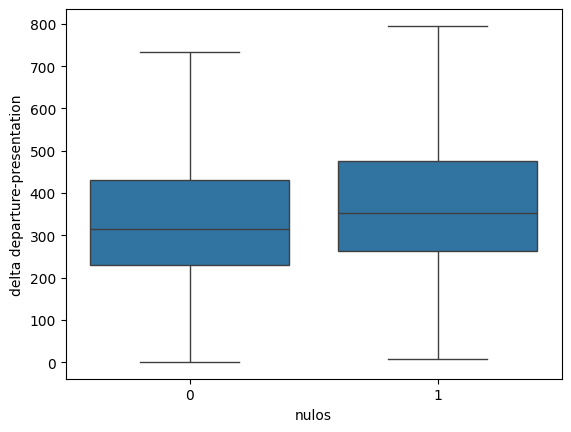

In [24]:
#Distribución de la variable respuesta en registros con y sin valores nulos en "location of the event"
df['nulos'] = np.where(df['location of the event'].isna(),1,0)

sns.boxplot(x = 'nulos' , y = 'delta departure-presentation', data = df,showfliers=False)

La siguiente celda de código ejemplifica cómo la distribución de la etiqueta sería la misma si los errores fueran aleatorios.
(Descomenta las líneas y observa las diferencias con los resultados anteriores)

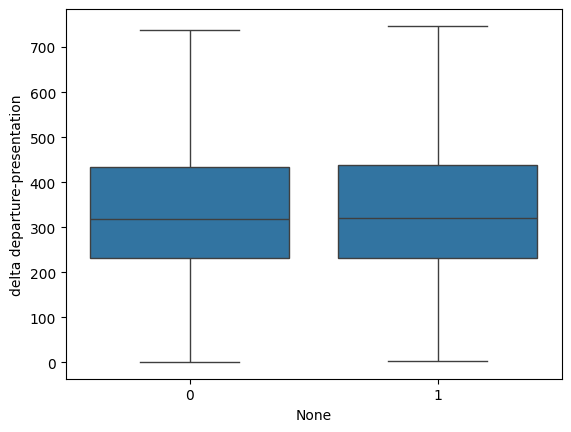

In [85]:
# muestra = pd.Series(0, index = y.index)
# muestra[y.sample(12710).index]=1
# y_muestra = df.loc[muestra==1, 'delta departure-presentation']
# y_NoMuestra = df.loc[muestra==0, 'delta departure-presentation']
# sns.boxplot(x = muestra , y = df['delta departure-presentation'], showfliers=False)
# plt.show()

**¿Podemos imputar valores con el conocimiento que tenemos de los demás registros?**

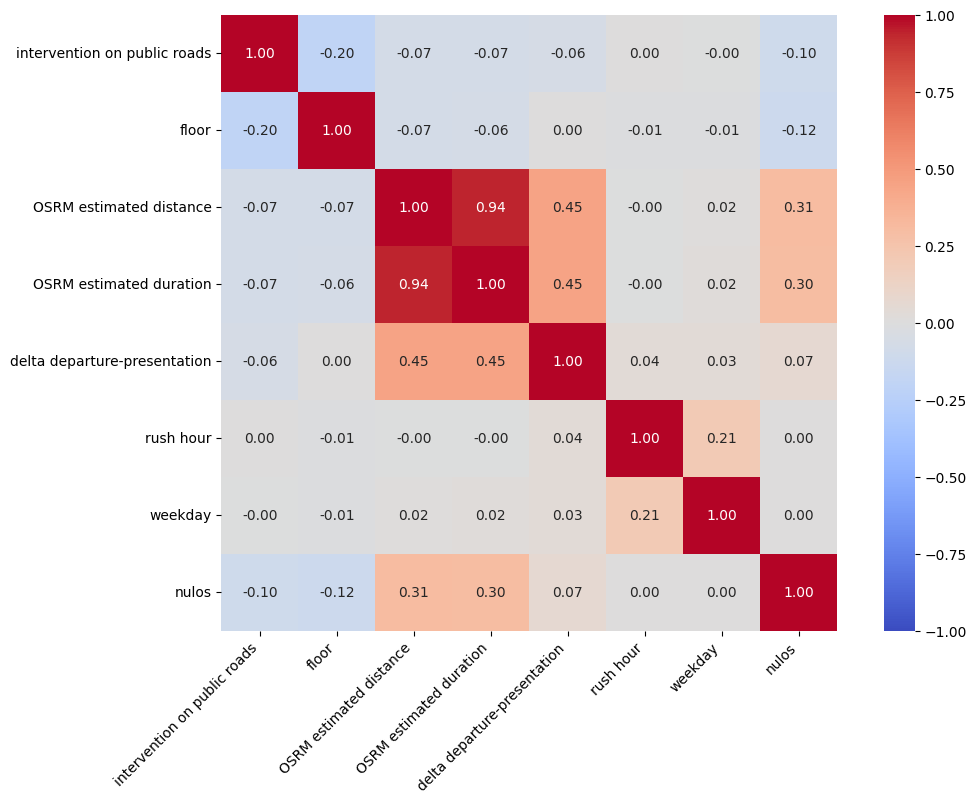

In [26]:
col_numericas = list(df.select_dtypes(include=['int64', 'float64', 'bool']).columns)
correlacion(df[col_numericas])

<Axes: xlabel='nulos', ylabel='alert reason category'>

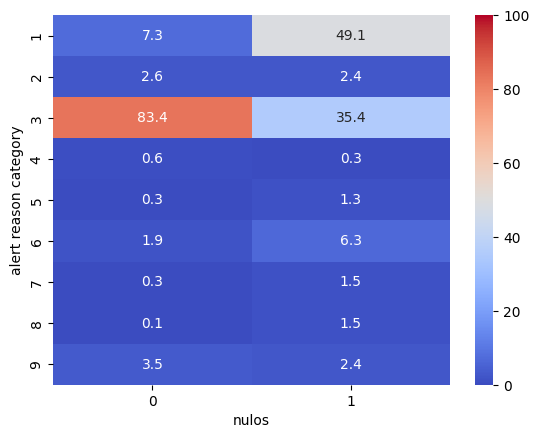

In [27]:
tabla = (pd.crosstab(df['alert reason category'],df['nulos'], normalize = 'columns')*100)

sns.heatmap(tabla,  vmin = 0, vmax = 100, cmap = "coolwarm", annot = True,
            fmt=".1f")

In [28]:
# Para imputar los valores nulos en 'alert reason category', tomamos la moda que le corresponda segun la categoria que tenga en 'location of the event'
dict_alert_location = df.groupby('alert reason category')['location of the event'].agg(pd.Series.mode).to_dict()
dict_alert_location

{1: 131.0,
 2: 149.0,
 3: 139.0,
 4: 139.0,
 5: 148.0,
 6: 148.0,
 7: 148.0,
 8: 131.0,
 9: 139.0}

In [29]:
# remplazamos los valores nulos en 'location of the event' de acuerdo al valor que presenta

df['location of the event'] = df['location of the event'].fillna( df['alert reason category'].map(dict_alert_location)).astype('object')
df['location of the event'].isna().sum()

0

In [30]:
# borrar la columna de nulos
df = df.drop('nulos', axis=1)


# One hot encoding variables categoricas

In [31]:
df[categoricas].nunique()

alert reason category       9
location of the event     210
emergency vehicle type     75
dtype: int64

In [32]:
describe_datos(df[categoricas])

,dtypes,null,nunique,unique
alert reason category,object,0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
location of the event,object,0,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
emergency vehicle type,object,0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."


In [33]:
he = pd.get_dummies(df[categoricas],
                   drop_first=True)
print(he.shape)
he.head()

(219337, 291)


,alert reason category_2,alert reason category_3,alert reason category_4,alert reason category_5,alert reason category_6,alert reason category_7,alert reason category_8,alert reason category_9,location of the event_101.0,location of the event_102.0,...,emergency vehicle type_VRCP,emergency vehicle type_VRM,emergency vehicle type_VRSD,emergency vehicle type_VSAV BALA,emergency vehicle type_VSAV BSPP,emergency vehicle type_VSAV SDIS,emergency vehicle type_VSAV SSLIA,emergency vehicle type_VSIS,emergency vehicle type_VSTI,emergency vehicle type_VTBA
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,
5105452,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4720915,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5365374,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4741586,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
5381209,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [34]:
df.columns

Index(['selection time', 'alert reason category',
       'intervention on public roads', 'floor', 'location of the event',
       'emergency vehicle type', 'OSRM estimated distance',
       'OSRM estimated duration', 'delta departure-presentation', 'rush hour',
       'weekday'],
      dtype='object')

In [35]:
df.shape, he.shape

((219337, 11), (219337, 291))

In [36]:
df = df.drop(columns=categoricas)
df = pd.concat([df, he], axis=1)
df.shape

(219337, 299)

In [37]:
#Llevar la etiqueta hasta la ultima posición

df = df[[c for c in df if c != 'delta departure-presentation'] + ['delta departure-presentation']]
print(df.shape)
df.info()

(219337, 299)
<class 'pandas.core.frame.DataFrame'>
Index: 219337 entries, 5105452 to 4868867
Columns: 299 entries, selection time to delta departure-presentation
dtypes: bool(292), datetime64[ns](1), float64(2), int64(4)
memory usage: 74.5 MB


In [38]:
df.columns

Index(['selection time', 'intervention on public roads', 'floor',
       'OSRM estimated distance', 'OSRM estimated duration', 'rush hour',
       'weekday', 'alert reason category_2', 'alert reason category_3',
       'alert reason category_4',
       ...
       'emergency vehicle type_VRM', 'emergency vehicle type_VRSD',
       'emergency vehicle type_VSAV BALA', 'emergency vehicle type_VSAV BSPP',
       'emergency vehicle type_VSAV SDIS', 'emergency vehicle type_VSAV SSLIA',
       'emergency vehicle type_VSIS', 'emergency vehicle type_VSTI',
       'emergency vehicle type_VTBA', 'delta departure-presentation'],
      dtype='object', length=299)

# Selección de variables

<h2> Eliminar variables no relevantes

Análisis de correlación con la variable respuesta

In [39]:
corr_y = df.corr()['delta departure-presentation'].abs()


In [40]:
corr_y.sort_values(ascending = False).head(40)

delta departure-presentation        1.000000
OSRM estimated distance             0.449922
OSRM estimated duration             0.446742
emergency vehicle type_VRCP         0.104753
emergency vehicle type_VID          0.102340
emergency vehicle type_VRM          0.078155
alert reason category_7             0.062347
alert reason category_5             0.058339
intervention on public roads        0.057065
emergency vehicle type_DEP          0.056944
emergency vehicle type_VTBA         0.055564
emergency vehicle type_VSAV BSPP    0.055509
location of the event_139.0         0.055087
emergency vehicle type_VPS          0.049377
location of the event_148.0         0.047335
emergency vehicle type_PEV          0.044703
rush hour                           0.038517
location of the event_259.0         0.037418
emergency vehicle type_VRSD         0.032930
weekday                             0.032906
alert reason category_6             0.032866
location of the event_325.0         0.029667
alert reas

In [41]:
no_relevantes = list(corr_y[corr_y.abs()<0.01].index)
print(len(no_relevantes))
df = df.drop(no_relevantes, axis=1)
df.shape

227


(219337, 72)

In [42]:
no_relevantes

['floor',
 'alert reason category_4',
 'alert reason category_8',
 'location of the event_101.0',
 'location of the event_102.0',
 'location of the event_103.0',
 'location of the event_104.0',
 'location of the event_105.0',
 'location of the event_106.0',
 'location of the event_109.0',
 'location of the event_110.0',
 'location of the event_111.0',
 'location of the event_112.0',
 'location of the event_113.0',
 'location of the event_114.0',
 'location of the event_115.0',
 'location of the event_116.0',
 'location of the event_118.0',
 'location of the event_119.0',
 'location of the event_120.0',
 'location of the event_121.0',
 'location of the event_122.0',
 'location of the event_123.0',
 'location of the event_124.0',
 'location of the event_125.0',
 'location of the event_126.0',
 'location of the event_127.0',
 'location of the event_128.0',
 'location of the event_129.0',
 'location of the event_130.0',
 'location of the event_131.0',
 'location of the event_132.0',
 'loca

In [43]:
len(df.columns)

72

<h2>Eliminar variables redundantes

Análisis de correlación entre las variables explicativas

In [44]:
# correlacion de las características en el conjunto X
corr_matrix = df.drop('delta departure-presentation', axis=1).corr()

In [45]:
corr_matrix

,selection time,intervention on public roads,OSRM estimated distance,OSRM estimated duration,rush hour,weekday,alert reason category_2,alert reason category_3,alert reason category_5,alert reason category_6,...,emergency vehicle type_VLR BSPP,emergency vehicle type_VPS,emergency vehicle type_VRA,emergency vehicle type_VRCH BSPP,emergency vehicle type_VRCP,emergency vehicle type_VRM,emergency vehicle type_VRSD,emergency vehicle type_VSAV BSPP,emergency vehicle type_VSTI,emergency vehicle type_VTBA
selection time,1.000000,0.014848,0.022811,0.022601,-0.005470,-0.011227,0.008428,-0.003778,0.004493,-0.002553,...,0.000306,-0.002303,0.001859,-0.001097,0.000031,0.002626,-0.002485,0.006768,0.003201,0.002493
intervention on public roads,0.014848,1.000000,-0.073699,-0.074695,0.000729,-0.003099,0.253388,-0.043652,0.020037,-0.007860,...,-0.033910,0.001381,-0.008579,-0.008487,-0.001978,-0.002167,-0.005935,0.074740,-0.001532,-0.001251
OSRM estimated distance,0.022811,-0.073699,1.000000,0.944066,-0.000392,0.015299,-0.010453,-0.062080,0.088653,0.009462,...,0.065832,0.050493,0.121794,0.077481,0.039606,0.016810,0.091897,-0.085182,0.011800,0.037347
OSRM estimated duration,0.022601,-0.074695,0.944066,1.000000,-0.000463,0.015969,-0.016825,-0.055284,0.077322,0.009611,...,0.061499,0.046170,0.102406,0.063714,0.033710,0.019304,0.074296,-0.083078,0.006953,0.033285
rush hour,-0.005470,0.000729,-0.000392,-0.000463,1.000000,0.209941,0.028203,-0.002918,-0.003816,0.004553,...,0.006365,0.000601,-0.004549,-0.001130,-0.002524,0.003564,-0.001410,-0.001430,0.001028,-0.001596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
emergency vehicle type_VRM,0.002626,-0.002167,0.016810,0.019304,0.003564,-0.000464,-0.000855,-0.010661,-0.000313,-0.000784,...,-0.000864,-0.000159,-0.000108,-0.000107,-0.000025,1.000000,-0.000075,-0.008551,-0.000019,-0.000016
emergency vehicle type_VRSD,-0.002485,-0.005935,0.091897,0.074296,-0.001410,-0.004520,-0.000341,-0.029199,0.009832,0.002200,...,-0.002365,-0.000436,-0.000297,-0.000293,-0.000068,-0.000075,1.000000,-0.023420,-0.000053,-0.000043
emergency vehicle type_VSAV BSPP,0.006768,0.074740,-0.085182,-0.083078,-0.001430,0.000131,0.054457,0.592738,-0.088963,-0.230511,...,-0.269923,-0.049761,-0.033853,-0.033491,-0.007806,-0.008551,-0.023420,1.000000,-0.006046,-0.004937
emergency vehicle type_VSTI,0.003201,-0.001532,0.011800,0.006953,0.001028,-0.002125,-0.000604,-0.007538,-0.000221,-0.000554,...,-0.000611,-0.000113,-0.000077,-0.000076,-0.000018,-0.000019,-0.000053,-0.006046,1.000000,-0.000011


In [46]:
#Identificar variables redundantes

# Triangulo superior de la matriz de correlación en números absolutos
celda_sobre_diagonal_ppal = np.triu(np.ones_like(corr_matrix),1).astype(bool)
triangulo_sup = corr_matrix.where(celda_sobre_diagonal_ppal).abs()


# Encontrar las columnas donde la correlación es 1
redundantes = [column for column in triangulo_sup.columns
          if any(triangulo_sup[column] >= .7)]
redundantes

['OSRM estimated duration']

In [47]:
df = df.drop('OSRM estimated duration', axis=1)

In [48]:
df.columns

Index(['selection time', 'intervention on public roads',
       'OSRM estimated distance', 'rush hour', 'weekday',
       'alert reason category_2', 'alert reason category_3',
       'alert reason category_5', 'alert reason category_6',
       'alert reason category_7', 'alert reason category_9',
       'location of the event_107.0', 'location of the event_108.0',
       'location of the event_136.0', 'location of the event_139.0',
       'location of the event_140.0', 'location of the event_143.0',
       'location of the event_148.0', 'location of the event_149.0',
       'location of the event_170.0', 'location of the event_196.0',
       'location of the event_199.0', 'location of the event_206.0',
       'location of the event_224.0', 'location of the event_228.0',
       'location of the event_252.0', 'location of the event_258.0',
       'location of the event_259.0', 'location of the event_261.0',
       'location of the event_264.0', 'location of the event_270.0',
       'loca

# Exploración de las variables numéricas

In [49]:
boleanas=[]
for col in df.columns:
  if df[col].nunique()==2:
    boleanas.append(col)
df[boleanas]=df[boleanas].astype('bool')

In [50]:
numericas = list(df.select_dtypes(include=['int64', 'float64']).columns)
numericas

['OSRM estimated distance', 'delta departure-presentation']

In [51]:
df[numericas].describe()


,OSRM estimated distance,delta departure-presentation
count,219337.000000,219337.000000
mean,2238.134131,356.161026
std,1591.647524,228.381939
min,0.800000,1.000000
25%,1221.100000,231.000000
50%,1866.800000,319.000000
75%,2834.600000,434.000000
max,42752.800000,22722.000000


<Axes: xlabel='OSRM estimated distance', ylabel='delta departure-presentation'>

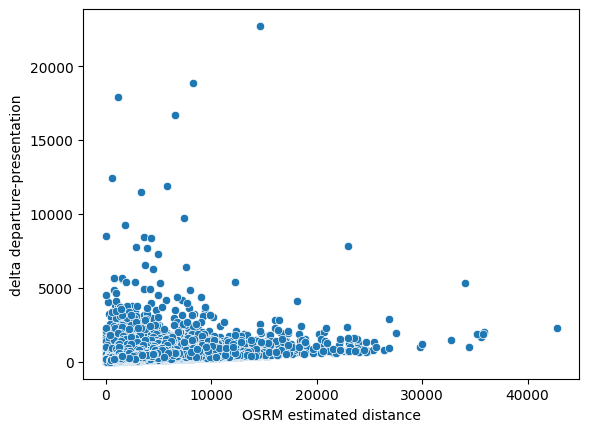

In [52]:
sns.scatterplot(x = df['OSRM estimated distance'],
                y = df['delta departure-presentation'])

# Exploración de Outliers

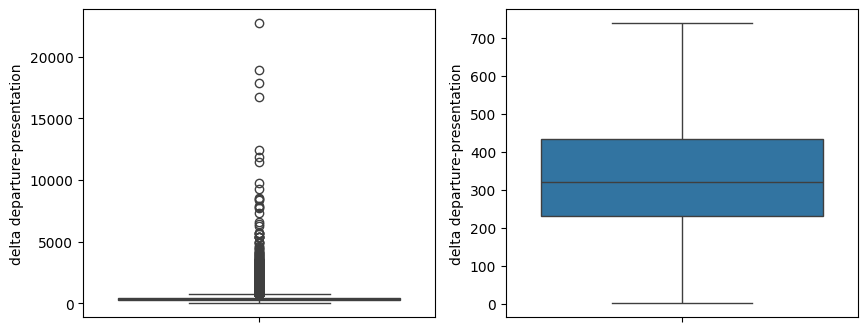

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for cond, subplot in zip((True, False), ax.flatten()):
  sns.boxplot(y=df['delta departure-presentation'], showfliers=cond, ax= subplot)

## Identificar "a ojo" *outliers*

In [54]:
df['delta departure-presentation'].describe()

count    219337.000000
mean        356.161026
std         228.381939
min           1.000000
25%         231.000000
50%         319.000000
75%         434.000000
max       22722.000000
Name: delta departure-presentation, dtype: float64

In [55]:
df['delta departure-presentation'].quantile(.975)

806.0

In [56]:
df['outlier'] = 0
filtro_out = df['delta departure-presentation'] > df['delta departure-presentation'].quantile(.975)
df.loc[filtro_out,'outlier'] = 1

In [57]:
df['outlier'].value_counts()

outlier
0    213857
1      5480
Name: count, dtype: int64

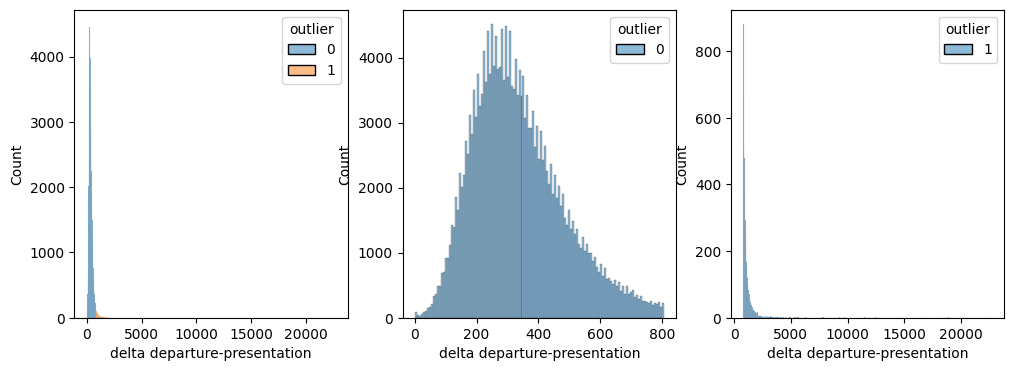

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for dat, subplot in zip((df, df[-filtro_out], df[filtro_out]), ax.flatten()):
  sns.histplot(x='delta departure-presentation', hue='outlier',
               data=dat, ax=subplot )
plt.show()

In [59]:
seleccion = ((df['OSRM estimated distance']>20350) & (df['OSRM estimated distance']<20500))
df[seleccion].T

emergency vehicle selection,4808363,5320305,4832811
selection time,2018-02-15 10:58:51.493000,2018-10-25 16:32:40.670000,2018-02-28 17:44:03.653000
intervention on public roads,False,False,False
OSRM estimated distance,20451.1,20373.2,20420.9
rush hour,False,True,True
weekday,True,True,True
...,...,...,...
emergency vehicle type_VSAV BSPP,False,False,False
emergency vehicle type_VSTI,False,False,False
emergency vehicle type_VTBA,False,False,False
delta departure-presentation,1171,609,1571


Revisa con atención los últimos dos registros mostrados

# Comparación Regresión lineal, Regresión robusta

In [60]:
y = df['delta departure-presentation']
X = df.drop(['selection time', 'delta departure-presentation', 'outlier'],
            axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=261)

# Guardamos datos preprocesados

In [61]:
df_preprocesado = pd.concat([X,y], axis=1)
#comprobamos dimensiones
X.shape,    y.shape,   df_preprocesado.shape

((219337, 69), (219337,), (219337, 70))

In [62]:
# df_preprocesado.to_csv('/content/drive/MyDrive/Datos/ParisFireBrigade/Output/df_selec.csv')

In [63]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("y: ", y_train.shape)

print("Conjunto de prueba")
print("X: ", X_test.shape)
print("y: ", y_test.shape)

Conjunto de entrenamiento
X:  (153535, 69)
y:  (153535,)
Conjunto de prueba
X:  (65802, 69)
y:  (65802,)


## Regresión Lineal

In [64]:
lr = LinearRegression().fit(X_train, y_train)

y_pred = lr.predict(X_test)

error_medio_absoluto = np.mean(np.absolute(y_test - y_pred ))
error_medio_absoluto

107.50207065419114

In [65]:
#calculamos los errores
errores = (np.array(y_test) - y_pred)
len(errores)

65802

In [66]:
#una de las hipotesis de la regresión es que los errores son
#independientes  entre sí, teniendo una distribución normal

media = np.mean(y_test - y_pred)
des_est = np.sqrt(np.var(y_test - y_pred))

media,des_est

(1.4356349301472804, 204.71368071827257)

### Comparación de los errores empirícos con una la distribución normal

In [67]:
y_test.shape

(65802,)

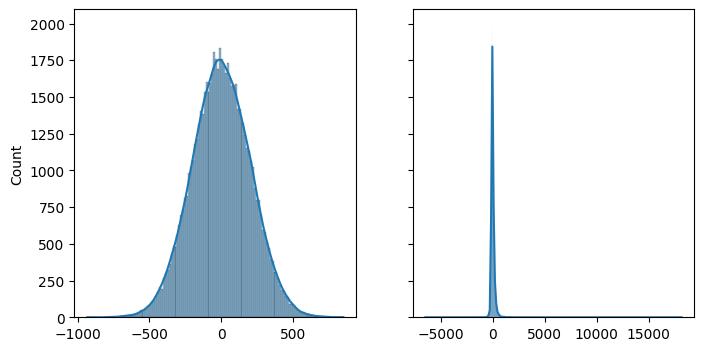

In [68]:
# Comparación de la distribución teórica(normal) y empirica de los errores

errores_teoricos = np.random.normal(media, des_est, 65802)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, errores), ax.flatten()):
  sns.histplot(x=dat, ax=subplot, kde=True, )

plt.show()

### Calculo de [$R^2$](https://docs.google.com/presentation/d/1k0aYwEBzaaAkWjX6jRKAc40nKHi3FROkJwtXCOE22mI/edit#slide=id.ga8926b2cd2_0_14)

$MSE = \cfrac{1}{n}\sum{( y - y_{pred})}^2$

 $R^2 	= 1 -  \cfrac{MSE(modelo)}{MSE(linea~base)}$


In [69]:
# Error cuadrado medio (MSE) linea base (promedio de las etiquetas)

errores_lb = y_test - y_test.mean()
MSE_base = pow(errores_lb,2).sum()/len(errores_lb)
MSE_base

52114.94299180111

In [70]:
#Error cuadrado medio (MSE) modelo
errores = y_test - y_pred

MSE_modelo = pow(errores,2).sum()/len(errores)
MSE_modelo

41909.75212087549

In [71]:
R2 = 1 - MSE_modelo/MSE_base #¿cuánto mejora la predicción nuestro modelo?
R2

0.19582082000034295

In [72]:
R2 = 1 - MSE_base/MSE_base
R2

0.0

In [73]:
def R_cuadrada(val_obs, val_pred):
  errores_lb = val_obs - val_obs.mean()
  errores_m = val_obs - val_pred
  MSE_base = pow(errores_lb,2).sum()/len(errores_lb)
  MSE_modelo = pow(errores,2).sum()/len(errores)
  R2 = 1 - MSE_modelo/MSE_base
  return R2

In [74]:
R_cuadrada(y_test, y_pred)

0.19582082000034295

In [75]:
metrics.r2_score(y_test, y_pred)

0.19582082000034295

## Regresión Robusta

In [76]:
hr = HuberRegressor(epsilon=1.35,   max_iter=1000,  alpha=0,  warm_start=False,
                    fit_intercept=True, tol=1e-05)
hr = hr.fit(X_train, y_train)
y_pred = hr.predict(X_test)

print(metrics.mean_absolute_error(y_test, y_pred))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

104.21378519524247
MAE: 104.21378519524247


In [77]:
hr.coef_

array([ -5.84570261,   0.06936732,  15.51379812,   9.7701004 ,
       -18.77532162,  -3.43536269,  12.86641197,  55.56364279,
        27.20109196,  10.54703229,   9.68990131,   8.21112857,
        17.55126483,  13.1242687 ,  23.34070644,   1.83876391,
        -0.06327848,  -1.09171584,   0.54288302,  -5.92334214,
        -2.3864826 ,   3.43185674,  -3.02099192,  -3.44698581,
         0.09648634,  -1.20675312, -14.8366687 ,  -1.4131527 ,
        -1.56952668,  -2.83261622,  -4.96716994,   0.16038351,
         0.31257416,  -3.80708065, -20.71158569,   1.88902382,
        19.78392094,  -0.41480164,   0.17610612,   0.1669717 ,
       -12.44939514, -15.44423783,   0.47422645,   3.99876408,
         1.8309216 ,  37.67038661,  -2.35099284,  -4.95836352,
        -0.8862084 ,   2.44597748,  27.72323239,   0.08219956,
         0.16439896,  -0.33908857,  -2.68480485,  -0.32833794,
        28.21065115,   0.07088343,  -1.00096644,   9.70938332,
         6.32808321,  -4.21533424,  -3.27438857,  -0.16

In [78]:
coeficientes_hr = pd.DataFrame({'coef':hr.coef_, 'variable':list(X.columns)})
coeficientes_hr.sort_values('coef').reset_index(drop=True)

,coef,variable
0,-20.711586,location of the event_325.0
1,-18.775322,alert reason category_2
2,-15.444238,emergency vehicle type_CRF
3,-14.836669,location of the event_259.0
4,-12.449395,emergency vehicle type_CRAC
...,...,...
64,27.201092,alert reason category_7
65,27.723232,emergency vehicle type_PSE
66,28.210651,emergency vehicle type_VID
67,37.670387,emergency vehicle type_FA


# Estandarizar valores para comparar importancia de variables

In [79]:
from sklearn.preprocessing import StandardScaler

In [80]:
X_estandarizados = X.copy()
columnas = X.columns

scaler = StandardScaler()

X_estandarizados[columnas] = scaler.fit_transform(X[columnas])

In [81]:
X_estandarizados.describe()

,intervention on public roads,OSRM estimated distance,rush hour,weekday,alert reason category_2,alert reason category_3,alert reason category_5,alert reason category_6,alert reason category_7,alert reason category_9,...,emergency vehicle type_VLR BSPP,emergency vehicle type_VPS,emergency vehicle type_VRA,emergency vehicle type_VRCH BSPP,emergency vehicle type_VRCP,emergency vehicle type_VRM,emergency vehicle type_VRSD,emergency vehicle type_VSAV BSPP,emergency vehicle type_VSTI,emergency vehicle type_VTBA
count,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,...,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05,2.193370e+05
mean,3.602327e-17,5.312784e-17,9.718507e-18,-1.130829e-16,-3.242742e-17,1.058669e-16,1.665104e-17,-2.747098e-17,-1.291752e-17,5.183204e-18,...,8.422706e-19,-9.394557e-18,-9.070607e-19,-2.688787e-18,3.239502e-19,-5.831104e-19,-4.340933e-18,3.443591e-17,1.425381e-18,1.409184e-18
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-4.143257e-01,-1.405675e+00,-5.286634e-01,-2.518152e+00,-1.634160e-01,-2.038334e+00,-5.977838e-02,-1.498015e-01,-6.422443e-02,-1.879141e-01,...,-1.650993e-01,-3.043639e-02,-2.070623e-02,-2.048467e-02,-4.774567e-03,-5.230288e-03,-1.432501e-02,-1.634913e+00,-3.698347e-03,-3.019681e-03
25%,-4.143257e-01,-6.389835e-01,-5.286634e-01,3.971167e-01,-1.634160e-01,4.905967e-01,-5.977838e-02,-1.498015e-01,-6.422443e-02,-1.879141e-01,...,-1.650993e-01,-3.043639e-02,-2.070623e-02,-2.048467e-02,-4.774567e-03,-5.230288e-03,-1.432501e-02,-1.634913e+00,-3.698347e-03,-3.019681e-03
50%,-4.143257e-01,-2.333023e-01,-5.286634e-01,3.971167e-01,-1.634160e-01,4.905967e-01,-5.977838e-02,-1.498015e-01,-6.422443e-02,-1.879141e-01,...,-1.650993e-01,-3.043639e-02,-2.070623e-02,-2.048467e-02,-4.774567e-03,-5.230288e-03,-1.432501e-02,6.116533e-01,-3.698347e-03,-3.019681e-03
75%,-4.143257e-01,3.747483e-01,-5.286634e-01,3.971167e-01,-1.634160e-01,4.905967e-01,-5.977838e-02,-1.498015e-01,-6.422443e-02,-1.879141e-01,...,-1.650993e-01,-3.043639e-02,-2.070623e-02,-2.048467e-02,-4.774567e-03,-5.230288e-03,-1.432501e-02,6.116533e-01,-3.698347e-03,-3.019681e-03
max,2.413560e+00,2.545460e+01,1.891563e+00,3.971167e-01,6.119350e+00,4.905967e-01,1.672846e+01,6.675501e+00,1.557040e+01,5.321580e+00,...,6.056960e+00,3.285541e+01,4.829464e+01,4.881698e+01,2.094431e+02,1.911941e+02,6.980799e+01,6.116533e-01,2.703911e+02,3.311608e+02


In [82]:

X_train, X_test, y_train, y_test = train_test_split(X_estandarizados, y, test_size=0.3,
                                                    shuffle=True, random_state=261)

In [83]:
hr_st = HuberRegressor( epsilon=1.35,   max_iter=1000,  alpha=0,  warm_start=False,
                    fit_intercept=True, tol=1e-05)
hr_st = hr.fit(X_train, y_train)

In [84]:
coeficientes_hr_st = pd.Series(hr_st.coef_, index= columnas)

coef_estand = pd.DataFrame(coeficientes_hr_st.sort_values())
coef_estand

,0
emergency vehicle type_CRAC,-9.498691
emergency vehicle type_VRA,-8.446420
emergency vehicle type_VRCH BSPP,-6.382708
emergency vehicle type_VE2I,-5.139378
emergency vehicle type_UMH 93,-3.494462
...,...
emergency vehicle type_PSE,9.946765
emergency vehicle type_VID,10.617247
emergency vehicle type_VRM,13.055427
emergency vehicle type_VTBA,18.416012


# Referencias

* García, S., Luengo, J., & Herrera, F. (2015). Data Preprocessing in Data Mining. Intelligent Systems Reference Library. doi:10.1007/978-3-319-10247-4


* Hawkins, D. M. (1980). Identification of Outliers. Springer Netherlands. https://doi.org/10.1007/978-94-015-3994-4


* McDonald, A. (2021, septiembre 8). Using the missingno Python library to Identify and Visualise Missing Data Prior to Machine Learning. Medium. https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

* Chandrashekar, G., & Sahin, F. (2014). A survey on feature selection methods. Computers & Electrical Engineering, 40(1), 16-28. https://doi.org/10.1016/j.compeleceng.2013.11.024


.


